<a href="https://colab.research.google.com/github/AJAV-TIP/ApplicationExample/blob/main/EOS_Zhu_et_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EoS sentivity analysis for hydrogen uptake in La$_{0.5}$Ce$_{0.5}$Ni$_{4}$Co at 40 °C as Reported by (Zhu et al., 2022)

Import common libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

Import library to retrieve molecular weight and density of constituent elements of the sample

In [ ]:
!pip install periodictable
import periodictable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for periodictable: filename=periodictable-1.7.0-py3-none-any.whl size=752513 sha256=492d0efa982d2cf4b8b4b196ab3f665e585ef883fd2c9db7779b528685b6ca15
  Stored in directory: /root/.cache/pip/wheels/7e/19/a2/fef5d0ca2b1ad2b199e863a6e796ad9d5efc86563d80c91a0c
Successfully built periodictable


Import library to obtain compressibility factor or other thermodynamic properties from an Equation of State (EoS)

In [ ]:
!pip install CoolProp
import CoolProp.CoolProp as CP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 17.5 MB/s eta 0:00:00


  Read pressure sensor data from a CSV file hosted in a public GitHub repository and store it in the objects `Pf` (Final Pressure) and `Pi` (Initial Pressure)

In [ ]:
url = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/Zhu_et_al_2022.csv')
dataframe = pd.read_csv(url)
print(dataframe.info())

Pf = dataframe['Pf_(MPa)']
Pi = dataframe['Pi_(MPa)']

dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pi_(MPa)  24 non-null     float64
 1   Pf_(MPa)  24 non-null     float64
dtypes: float64(2)
memory usage: 512.0 bytes
None


,Pi_(MPa),Pf_(MPa)
0,0.000000,0.000001
1,0.090528,0.045081
2,0.116287,0.080403
3,0.168508,0.123850
4,0.295025,0.209278
5,0.454977,0.332466
6,0.630603,0.481468
7,0.851138,0.665709
8,1.108156,0.885624
9,1.421140,1.151234


Declare the elements of the material to be analyzed and retrieve the molecular weights and densities of the elements from the ‘Periodictable’ library.



In [ ]:
# List the symbols of the elements in your sample.
element_symbols = ['La', 'Ce', 'Ni', 'Co']
Mw=[]
# Function to retrieve and store molecular weights in the vector.
def get_Mw(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        Mw.append(element.mass)
# Function evaluation
get_Mw(element_symbols)

rho = []
# Function to retrieve and store solid state densities in the vector.
def get_rho(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        rho.append(element.density)

get_rho(element_symbols)

# Results of consult at the Periodic table library
Mw_H2 = 2*periodictable.elements.symbol('H').mass
rho_H = periodictable.elements.symbol('H').density

print("Elements densities",rho,"g/cm^3")
print("Molecular weights",Mw,"g/mol")
print("H density",rho_H,"g/cm^3")
print("H2 molecular weight",Mw_H2,"g/mol")

Elements densities [6.145, 6.77, 8.902, 8.9] g/cm^3
Molecular weights [138.9055, 140.116, 58.6934, 58.9332] g/mol
H density 0.0708 g/cm^3
H2 molecular weight 2.01588 g/mol


The sample weight is included, along with the coefficients of the elements that make up the sample, and the initial mass fractions are calculated

In [ ]:
m_host = 1.6194 # g of sample
Mw = np.array(Mw)
rho = np.array(rho)
Coeff = np.array([0.5, 0.5, 4, 1]) # coefficients of the elements that make up the sample
Mw_host = np.dot(Mw,Coeff) # molecular weight of the sample
w_i = Mw*Coeff/Mw_host # initial mass fractions

Insert the calibrated volumes

In [ ]:
V_rev = 12.098 #Reference volume Z.I
V_tube = 8.823 #Tube volume Z.II
V_sc = 2.91 # Sample cell volume Z.III

Insert temperatures

In [ ]:
T_rev = 298 # Reference  T (K) Z.I
T_tube = 298 # Tubes  T (K) Z.I
T_sc = 313 # Sample cell  T (K) Z.I

In [ ]:
dfX = pd.DataFrame(index=range(len(Pi)),columns=['Leach','SRK', 'PR',	'GI'])

Calculate hydrogen uptake in wt%

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Leach = pd.DataFrame(X)
dfX.Leach

0     0.000000
1     0.011229
2     0.013101
3     0.018717
4     0.026203
5     0.031819
6     0.043048
7     0.058023
8     0.074867
9     0.095451
10    0.134736
11    0.282611
12    0.531526
13    0.767338
14    1.012531
15    1.210917
16    1.330684
17    1.386806
18    1.405513
19    1.418602
20    1.431679
21    1.440995
22    1.446590
23    1.450386
Name: Leach, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P|gas', Pi[i]*1e6, 'SRK::Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P|gas', Pf[i]*1e6, 'SRK::Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P|gas', Pf[i-1]*1e6, 'SRK::Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P|gas', Pf[i]*1e6, 'SRK::Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P|gas', Pf[i-1]*1e6, 'SRK::Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P|gas', Pf[i]*1e6, 'SRK::Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.SRK = pd.DataFrame(X)
dfX.SRK

0     0.000000
1     0.011245
2     0.013112
3     0.018735
4     0.026262
5     0.031939
6     0.043230
7     0.058307
8     0.075280
9     0.096055
10    0.135603
11    0.283532
12    0.532985
13    0.769556
14    1.015614
15    1.214851
16    1.335692
17    1.392659
18    1.412063
19    1.425714
20    1.439853
21    1.450243
22    1.456527
23    1.459561
Name: SRK, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P|gas', Pi[i]*1e6, 'PR::Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P|gas', Pf[i]*1e6, 'PR::Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P|gas', Pf[i-1]*1e6, 'PR::Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P|gas', Pf[i]*1e6, 'PR::Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P|gas', Pf[i-1]*1e6, 'PR::Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P|gas', Pf[i]*1e6, 'PR::Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.PR = pd.DataFrame(X)
dfX.PR

0     0.000000
1     0.011297
2     0.013148
3     0.018794
4     0.026467
5     0.032356
6     0.043870
7     0.059318
8     0.076774
9     0.098282
10    0.138875
11    0.286998
12    0.538518
13    0.778068
14    1.027576
15    1.230295
16    1.355769
17    1.416643
18    1.439529
19    1.456215
20    1.476240
21    1.493313
22    1.504832
23    1.503980
Name: PR, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0))

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1])

    T1 = Pi[i]/(1*T_rev)
    T2 = Pf[i]/(1*T_rev)
    T3 = Pf[i-1]/(1*T_tube)
    T4 = Pf[i]/(1*T_tube)
    T5 = Pf[i-1]/(1*T_sc)
    T6 = Pf[i]/(1*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i]
    m_x[i] = m_host + n_sor[i-1]*Mw_host

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i])))
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2)

ld = round(X[i]+0.5)
dfX.GI = pd.DataFrame(X)
dfX.GI

0     0.000000
1     0.011355
2     0.013188
3     0.018858
4     0.026695
5     0.032829
6     0.044607
7     0.060508
8     0.078578
9     0.101063
10    0.143118
11    0.291473
12    0.545725
13    0.789357
14    1.043709
15    1.251496
16    1.384244
17    1.451790
18    1.481179
19    1.503997
20    1.536322
21    1.568841
22    1.594289
23    1.585848
Name: GI, dtype: float64

Generate plot

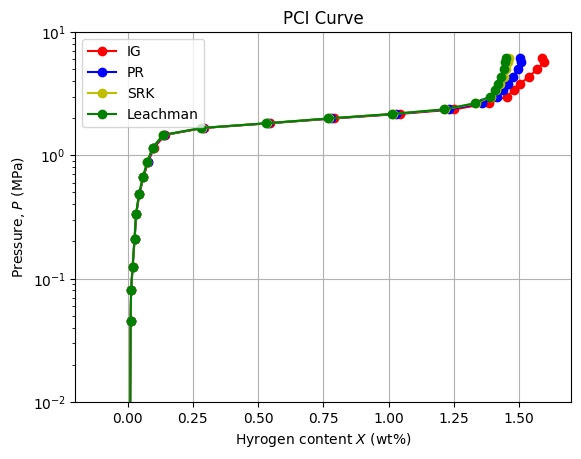

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Hyrogen content $X$ (wt%)')
ax.set_ylabel('Pressure, $P$ (MPa)')
ax.set_xlim([-0.2,1.7])
ax.set_ylim([0.01,10])
ax.set_yscale('log')
ax.grid(True)


ax.plot(dfX.GI,Pf,'ro-', label = 'IG')
ax.plot(dfX.PR,Pf,'bo-', label = 'PR')
ax.plot(dfX.SRK,Pf,'yo-', label = 'SRK')
ax.plot(dfX.Leach,Pf,'go-', label = 'Leachman')
ax.legend()
ax.set_title('PCI Curve')
plt.show()

In [ ]:
dfX

,Leach,SRK,PR,GI
0,0.000000,0.000000,0.000000,0.000000
1,0.011229,0.011245,0.011297,0.011355
2,0.013101,0.013112,0.013148,0.013188
3,0.018717,0.018735,0.018794,0.018858
4,0.026203,0.026262,0.026467,0.026695
5,0.031819,0.031939,0.032356,0.032829
6,0.043048,0.043230,0.043870,0.044607
7,0.058023,0.058307,0.059318,0.060508
8,0.074867,0.075280,0.076774,0.078578
9,0.095451,0.096055,0.098282,0.101063
